# 0.0 IMPORTS

In [126]:
import pandas as pd
import inflection
import math
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from datetime     import datetime, timedelta
from tabulate     import tabulate
from scipy        import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [56]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
# função para calcular o v de cramer para correlacionar 2 variáveis categóricas
# quanto mais o valor de retorno se aproximar de zero menor é a correlação , quanto mais próximo de 1 maior a correlação
def v_de_cramer( x, y):
    # gerando a matriz de contigência (cm) correlacionando 2 atributos categóricos
    cm = pd.crosstab( x, y ).values
    
    # pega a soma, o total de 
    n = cm.sum()
    r, k = cm.shape   # linhas e colunas 

    # função que cálcula o chi2 a partir da matriz de contigência(cm) e pega o primeiro valor de retorno 
    chi2 = ss.chi2_contingency( cm)[0]
    
    # aplicando as fórmulas para o cálculos corrigidos para as variavéis chi2, k , r
    chi2_corr =  max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)


    # fórmula do v de Cramér que é o método utilizado para fazer correlação entre atributos categóricos
    return np.sqrt( ( chi2_corr/n ) / ( min( k_corr-1, r_corr-1) ) )

In [57]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\datam\Anaconda3\envs\my_projects_env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2 Loading data

In [58]:
df_sales = pd.read_csv('data/train.csv', low_memory=False)
df_store = pd.read_csv('data/store.csv', low_memory=False)

# merging data
df = pd.merge(df_sales, df_store, how='left', on='Store')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

## 1.1 Rename Columns

In [59]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# changing column name format
snakecase = lambda x: inflection.underscore(x)
cols_new = list( map( snakecase, cols_old))

df.columns = cols_new
df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [60]:
df.shape

(1017209, 18)

## 1.3 Data Types

In [61]:
# changing data type object --> datetime
df['date'] = pd.to_datetime( df['date'])
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [62]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [63]:
#competition_distance  
df['competition_distance'] = df['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x )

#competition_open_since_month    
df['competition_open_since_month'] = df.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year    
df['competition_open_since_year'] = df.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )
                          
#promo2_since_week               
df['promo2_since_week'] = df.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

#promo2_since_year  
df['promo2_since_year'] = df.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

#promo_interval         

# criando um dicionário com o nome dos meses
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec',}

# atribuindo zero aos valores ausentes na coluna promo_interval
df['promo_interval'].fillna(0, inplace=True)

# pega o mês da venda e atribui como string usando o dicionario numa coluna nova
df['month_map'] = df['date'].dt.month.map( month_map)

# novo campo para saber se estava em promoção ou não
df['is_promo'] = df[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)



## 1.6 Change Types

In [64]:
# depois de abastecer dados é recomendável observar se houve mudanças ou inconsistências nos tipos de dados
df['competition_open_since_month'] = df['competition_open_since_month'].astype( np.int64)
df['competition_open_since_year']  = df['competition_open_since_year'].astype( np.int64)

df['promo2_since_week'] = df['promo2_since_week'].astype( np.int64)
df['promo2_since_year'] = df['promo2_since_year'].astype( np.int64)

df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [65]:
df_num = df.select_dtypes(include=['int64','float64'])
df_cat = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [66]:
# Central Tendency - mean, median
df_mean =   pd.DataFrame( df_num.apply( np.mean) ).T
df_median = pd.DataFrame( df_num.apply( np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
df_std =   pd.DataFrame( df_num.apply( np.std) ).T
df_min =   pd.DataFrame( df_num.apply( min ) ).T
df_max =   pd.DataFrame( df_num.apply( max ) ).T
df_range = pd.DataFrame( df_num.apply( lambda x: x.max() - x.min() ) ).T
df_skew =  pd.DataFrame( df_num.apply( lambda x: x.skew() ) ).T
df_kurt =  pd.DataFrame( df_num.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurt]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

<AxesSubplot:xlabel='assortment', ylabel='sales'>

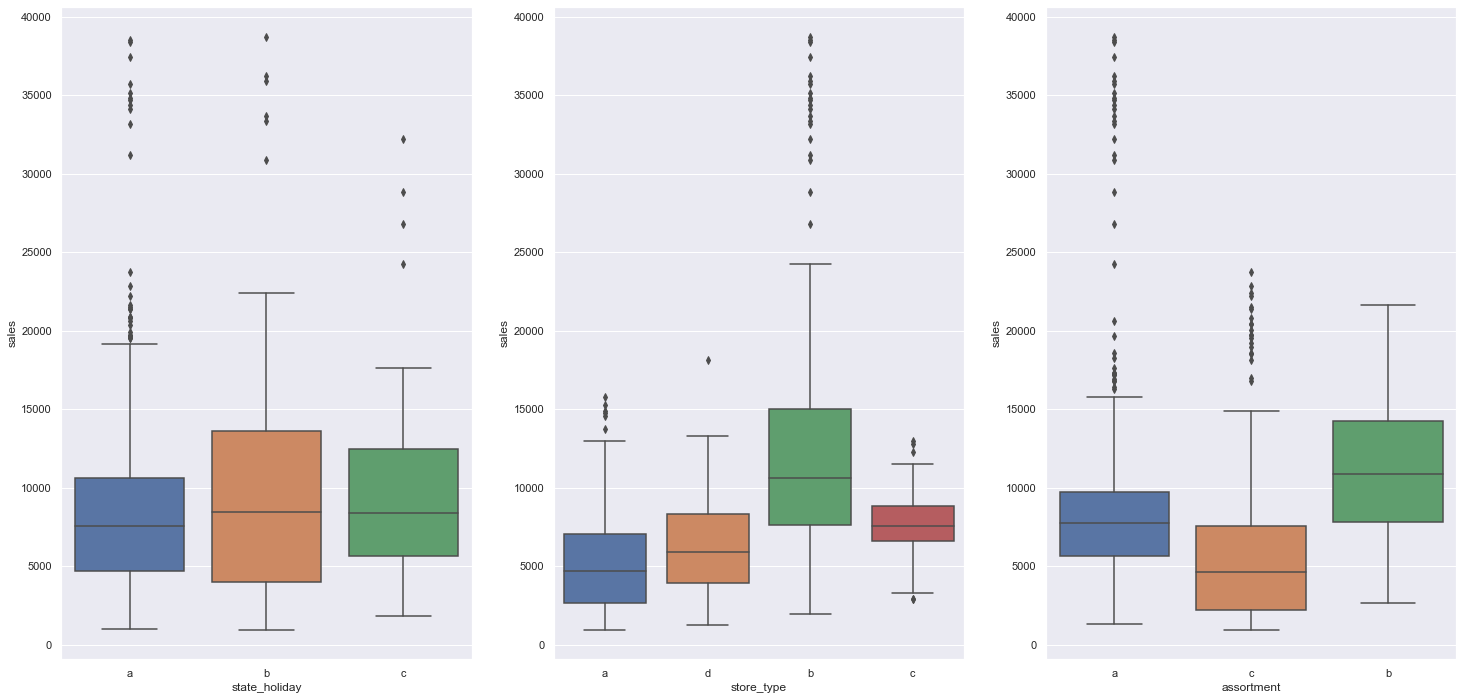

In [67]:
aux1 = df[( df['state_holiday'] != '0' ) & ( df['sales'] >0 )]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data = aux1)

# 2.0 FEATURE ENGINEERING

In [68]:
df2 = df.copy()

## 2.1 Mapa Mental de Hipóteses

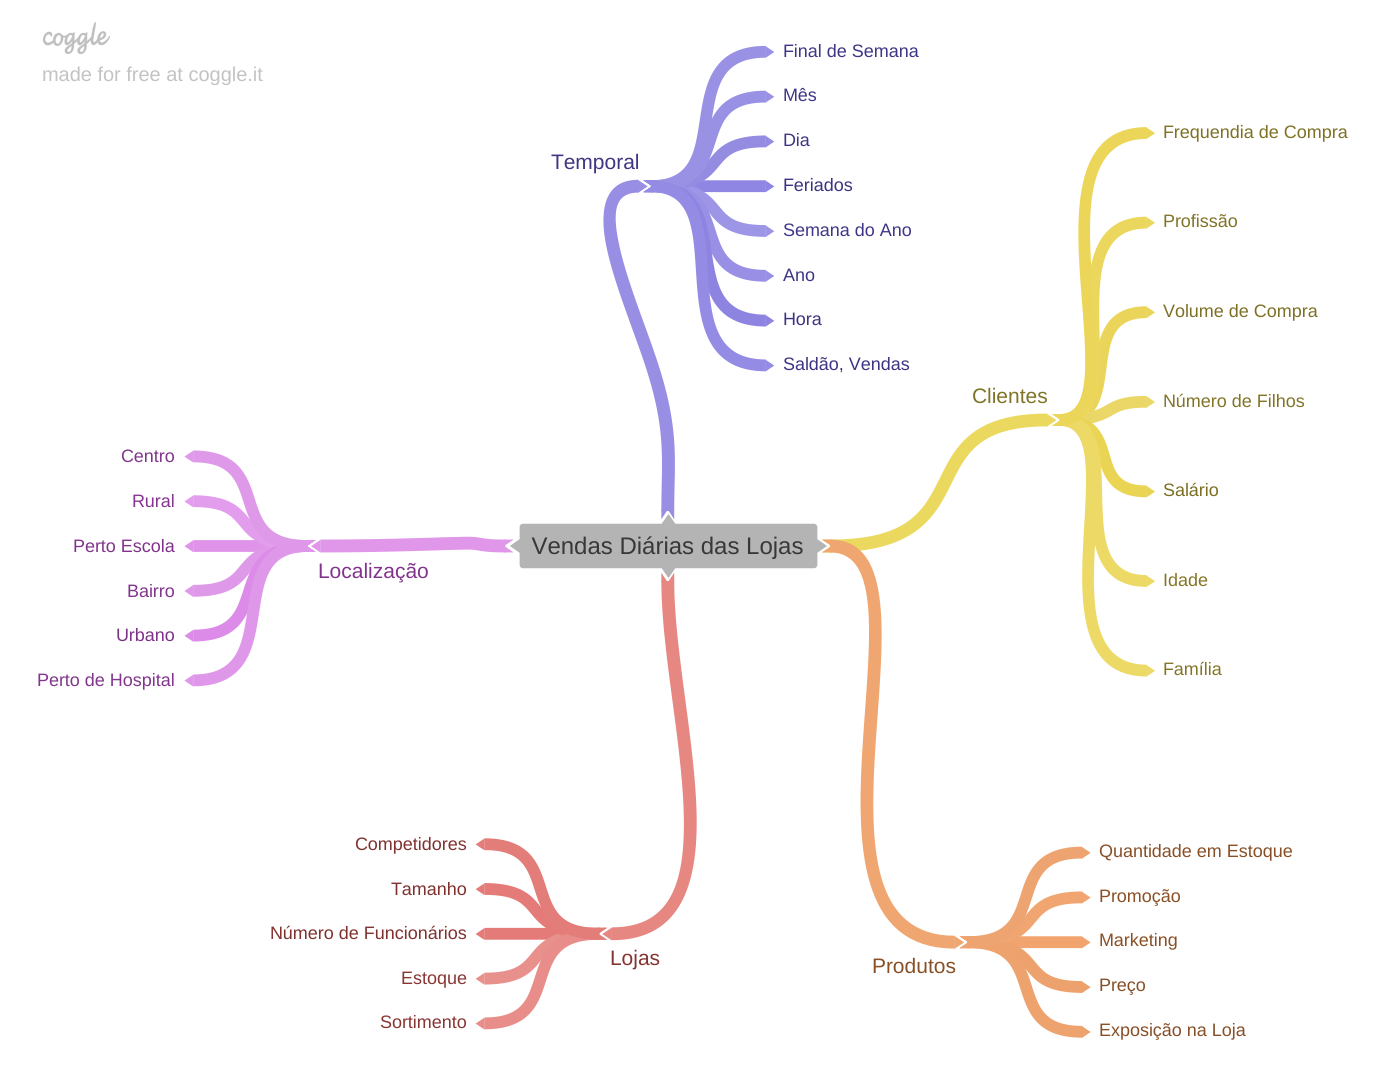

In [69]:
Image('img/MapaMentalHipoteses.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Enginnering

In [70]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply(lambda x: x.days).astype( int)
df2['competition_time_month'] = df2['competition_time_month'].astype( np.int64)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - timedelta( days=7) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7).apply(lambda x: x.days).astype( int)
df2['promo_time_week'] = df2['promo_time_week'].astype( np.int64)

# assortment a=basic, b=extra, c=extended
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day' )

C:\Users\datam\Anaconda3\envs\my_projects_env\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [71]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FILTRAGEM DE VARIÁVEIS 

In [72]:
df3 = df2.copy()

## 3.1 Filtragem das Linhas

In [73]:
# retirando as linhas que indicam que a loja estava fechada e que não houve vendas
df3 = df3[ ( df['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2 Seleção das Colunas

In [74]:
# removendo as colunas que não serão aplicadas no modelo, 
# customers pq n

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [75]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

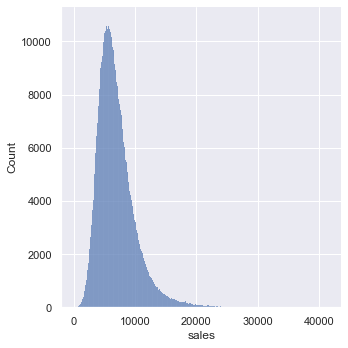

In [76]:
sns.displot( df4['sales'], kde=False)

### 4.1.2 Variáveis Numéricas

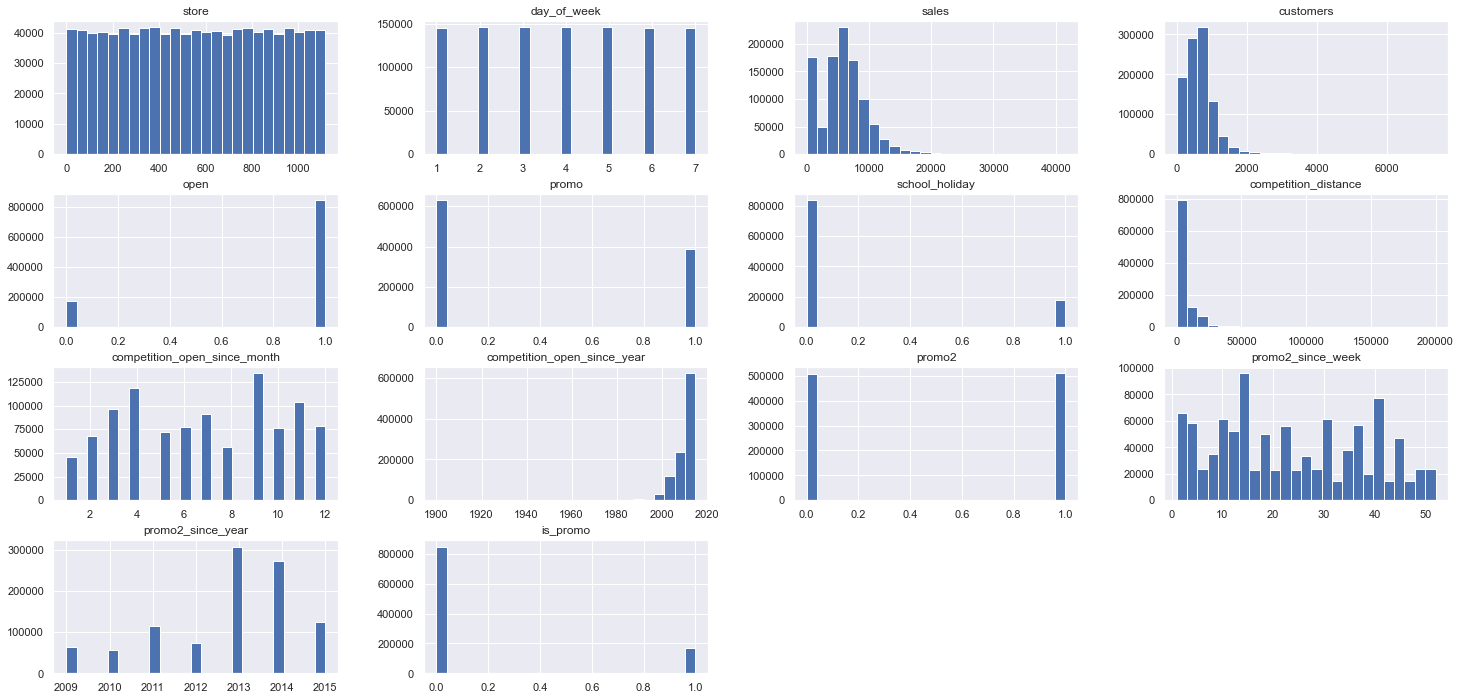

In [77]:
df_num.hist( bins=25);

### 4.1.3 Variáveis Categóricas

<AxesSubplot:xlabel='sales', ylabel='Density'>

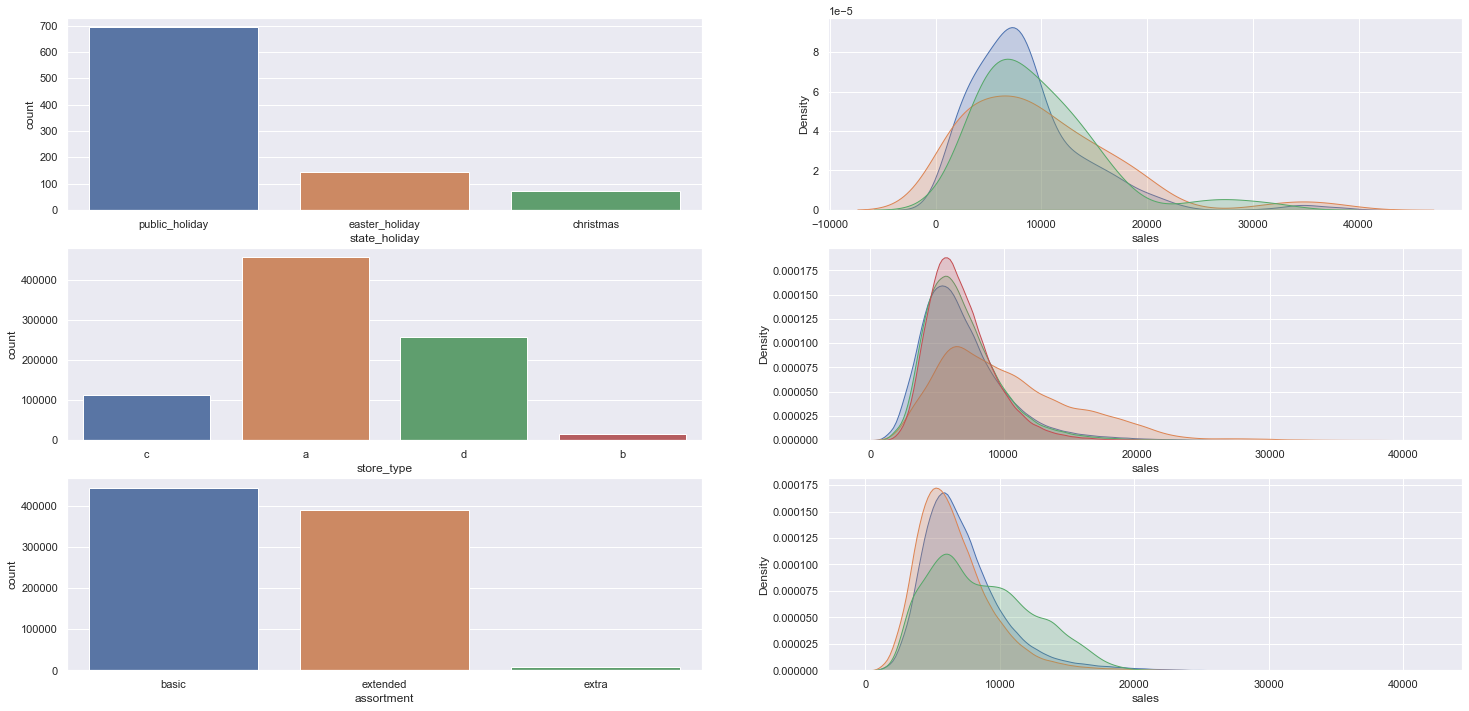

In [78]:
# state_holiday
plt.subplot( 3, 2, 1 )
sns.countplot( data=df4[df4['state_holiday'] != 'regular_day'], x='state_holiday' )

plt.subplot( 3, 2, 2 )
sns.kdeplot( data=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( data=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( data= df4, x='store_type' )

plt.subplot( 3, 2, 4 )
sns.kdeplot( data=df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( data=df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( data=df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( data=df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( data=df4, x='assortment' )

plt.subplot( 3, 2, 6 )
sns.kdeplot( data=df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( data=df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( data=df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )



## 4.2 Análise Bivariada

### Hipótese 1: Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

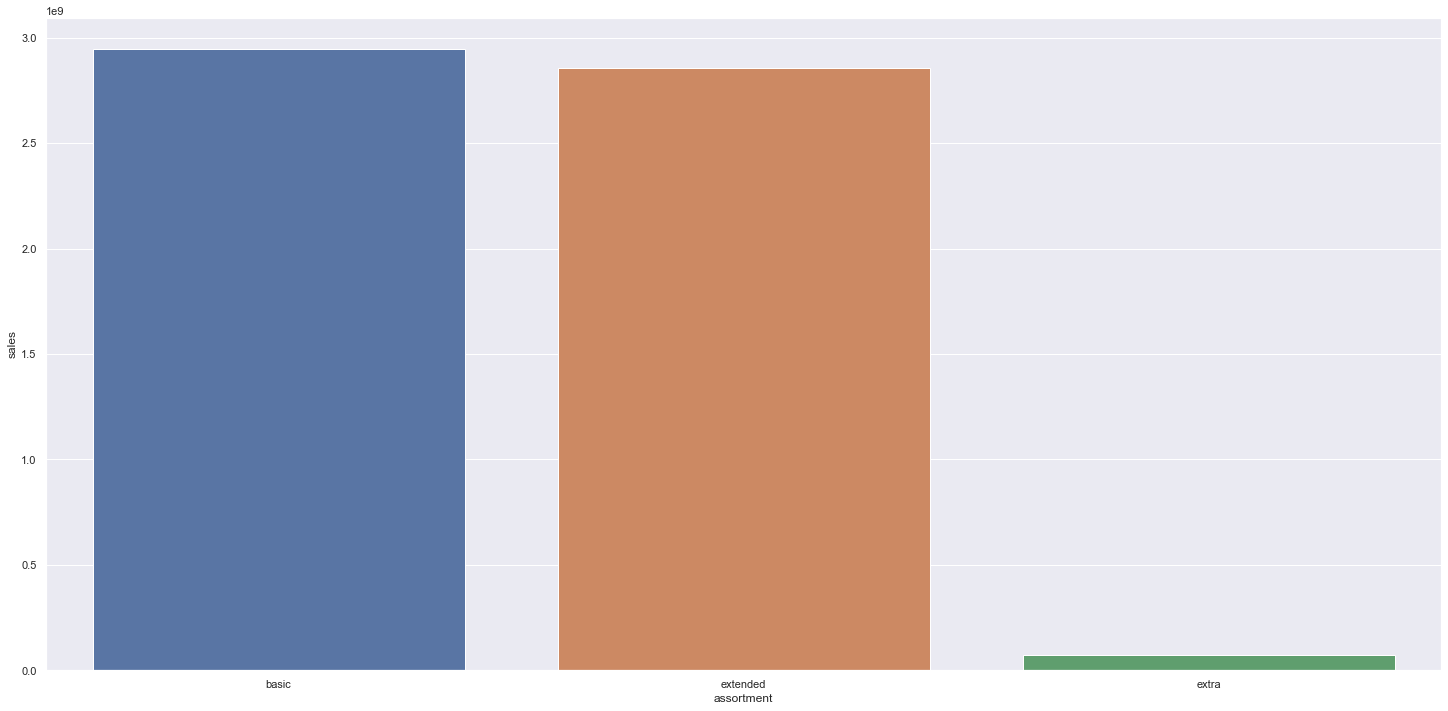

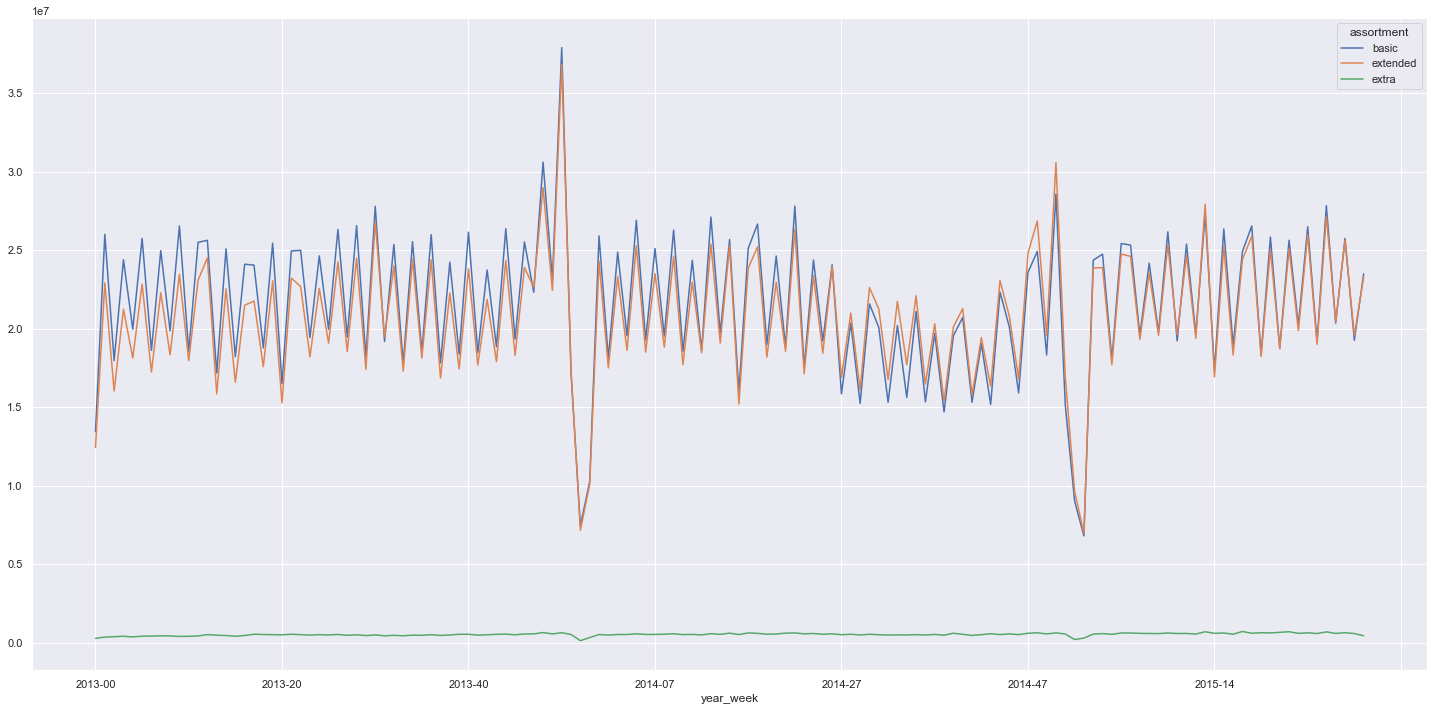

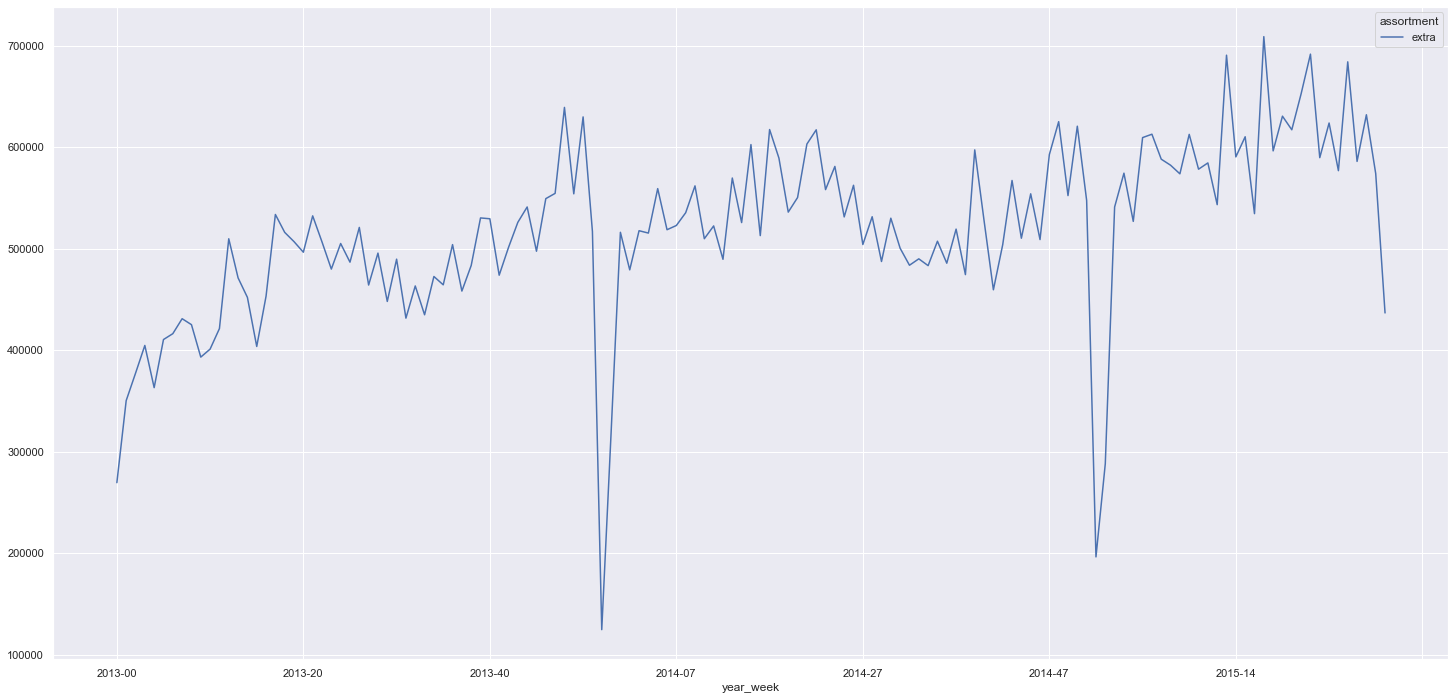

In [79]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( data=aux1, x='assortment', y='sales');

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot();




### Hipótese 2: Lojas com competidores mais próximos deveriam vender menos.
**FALSA**, Lojas COM COMPETIDORES MAIS PRÓXIMOS vendem MAIS

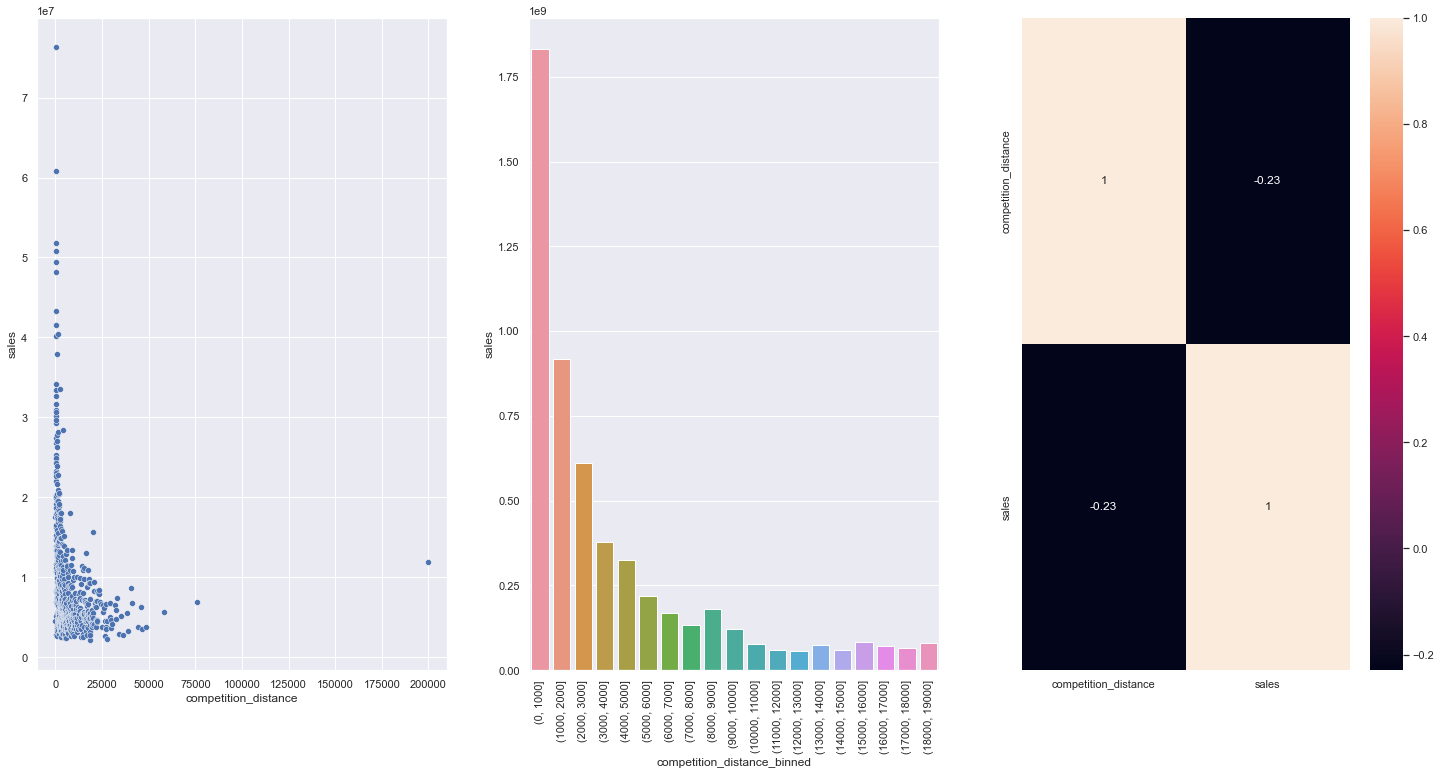

In [80]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# plot no gráfico de pontos scatterplot pois os valores da distancia são muito dispersos
plt.subplot( 1, 3, 1)
sns.scatterplot( data=aux1, x='competition_distance', y='sales');

# como as distâncias são valores muito dispersos, utilizaremos o recurso dos bins para agrupar esse campo a cada 1000
bins = list( np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot( 1, 3, 2)
plt.xticks( rotation=90)
sns.barplot( data=aux2, x='competition_distance_binned', y='sales');

# gráfico que faz a correlação entre duas variáveis
plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### Hipótese 3: Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas COM COMPETIDORES À MAIS TEMPO vendem MENOS

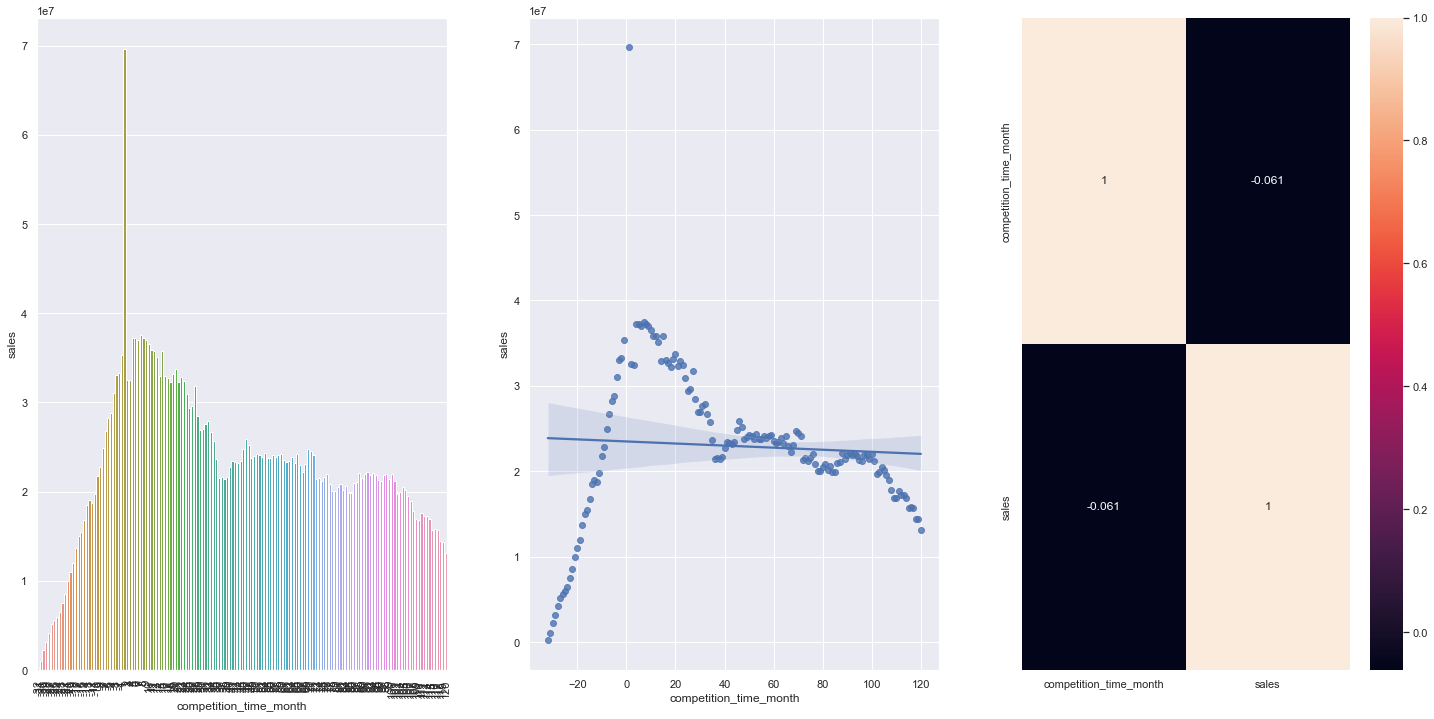

In [81]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# plot no gráfico de pontos scatterplot pois os valores da distancia são muito dispersos
#plt.subplot( 1, 2, 1)
#sns.scatterplot( data=aux1, x='competition_time_month', y='sales');


# como o tempo está muito dispersos, utilizaremos o recurso dos bins para agrupar esse campo a cada 1000
aux2 = aux1[( aux1['competition_time_month'] <= 120) & ( aux1['competition_time_month'] != 0)]

plt.subplot( 1, 3, 1)
plt.xticks( rotation=90)
sns.barplot( data=aux2, x='competition_time_month', y='sales');

plt.subplot( 1, 3, 2)
sns.regplot( data=aux2, x='competition_time_month', y='sales');

# gráfico que faz a correlação entre duas variáveis
plt.subplot( 1, 3, 3)
sns.heatmap( aux2.corr( method='pearson'), annot=True);

### Hipótese 4:  Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA**, Lojas com PROMOÇÔES ATIVAS POR MAIS TEMPO vendem MENOS a partir de um determinado período da promoção

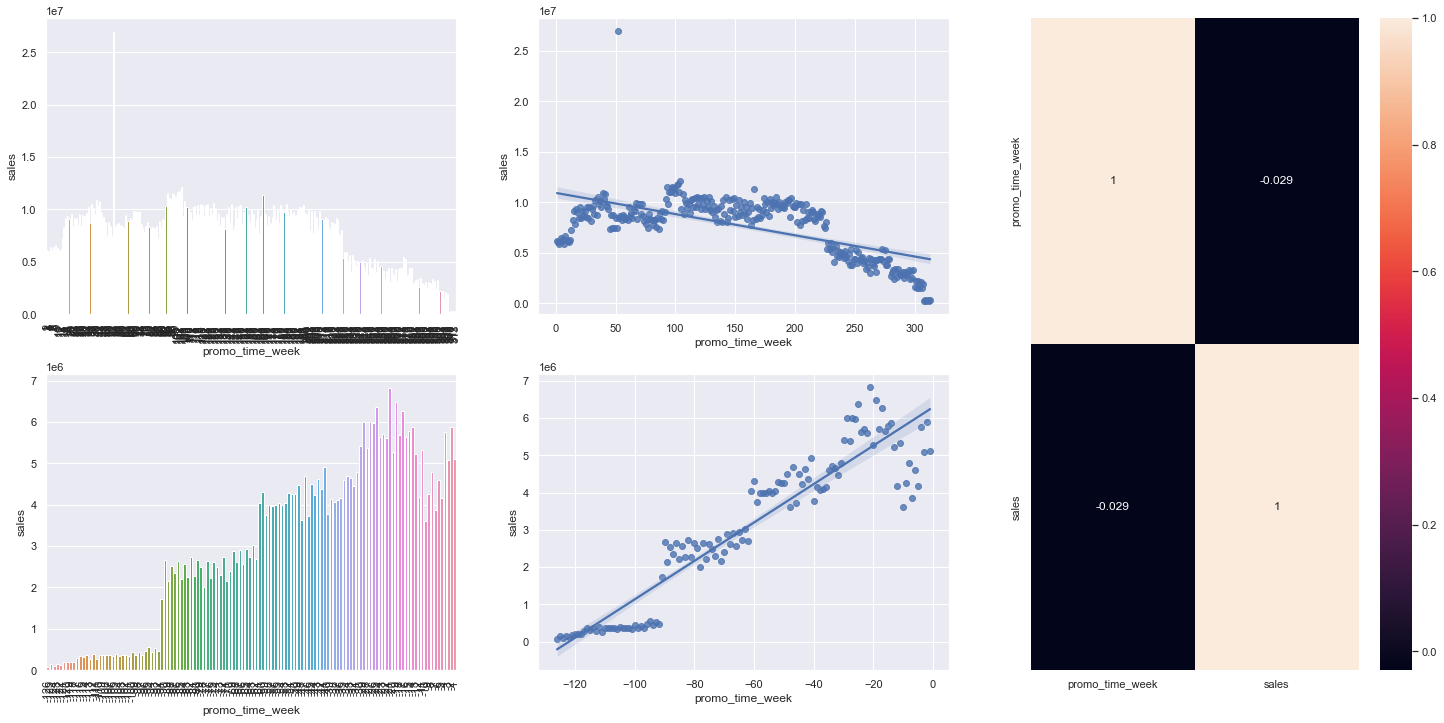

In [82]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# permite criar gráficos não quadrados por exemplo 2 linhas por 3 colunas
grid = GridSpec( 2,3 )

aux2 = aux1[aux1['promo_time_week'] > 0 ] # promoção extendida
plt.subplot( grid[0,0] )
plt.xticks( rotation=90)
sns.barplot( data=aux2, x='promo_time_week', y='sales');

plt.subplot( grid[0,1] )
sns.regplot( data=aux2, x='promo_time_week', y='sales');

aux3 = aux1[aux1['promo_time_week'] < 0 ] # promoção normal
plt.subplot( grid[1,0] )
plt.xticks( rotation=90)
sns.barplot( data=aux3, x='promo_time_week', y='sales');

plt.subplot( grid[1,1] )
sns.regplot( data=aux3, x='promo_time_week', y='sales');

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### <s>Hipótese 5:  Lojas com mais dias de promoção deveriam vender mais. </s>

### Hipótese 6: Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com MAIS PROMOÇÔES CONSECUTIVAS vendem MENOS

In [83]:
df4[['promo','promo2', 'sales']].groupby( ['promo','promo2']).sum().sort_values('sales', ascending=False).reset_index()

,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


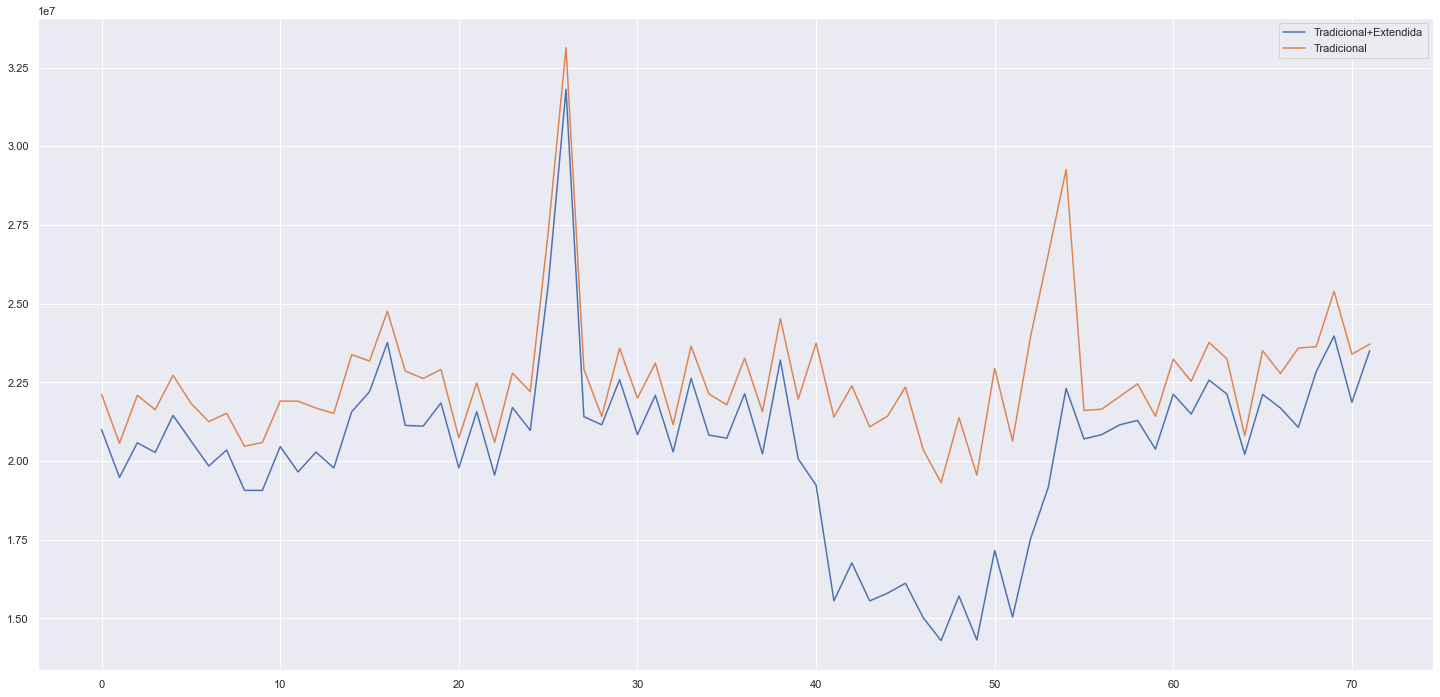

In [84]:
# promoção normal e extendida
aux1 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# promoção normal e extendida
aux2 = df4[( df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);
ax.legend( labels=['Tradicional+Extendida', 'Tradicional']);


### Hipótese 7: Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas ABERTAS DURANTE O FERIADO DO NATAL vendem MENOS

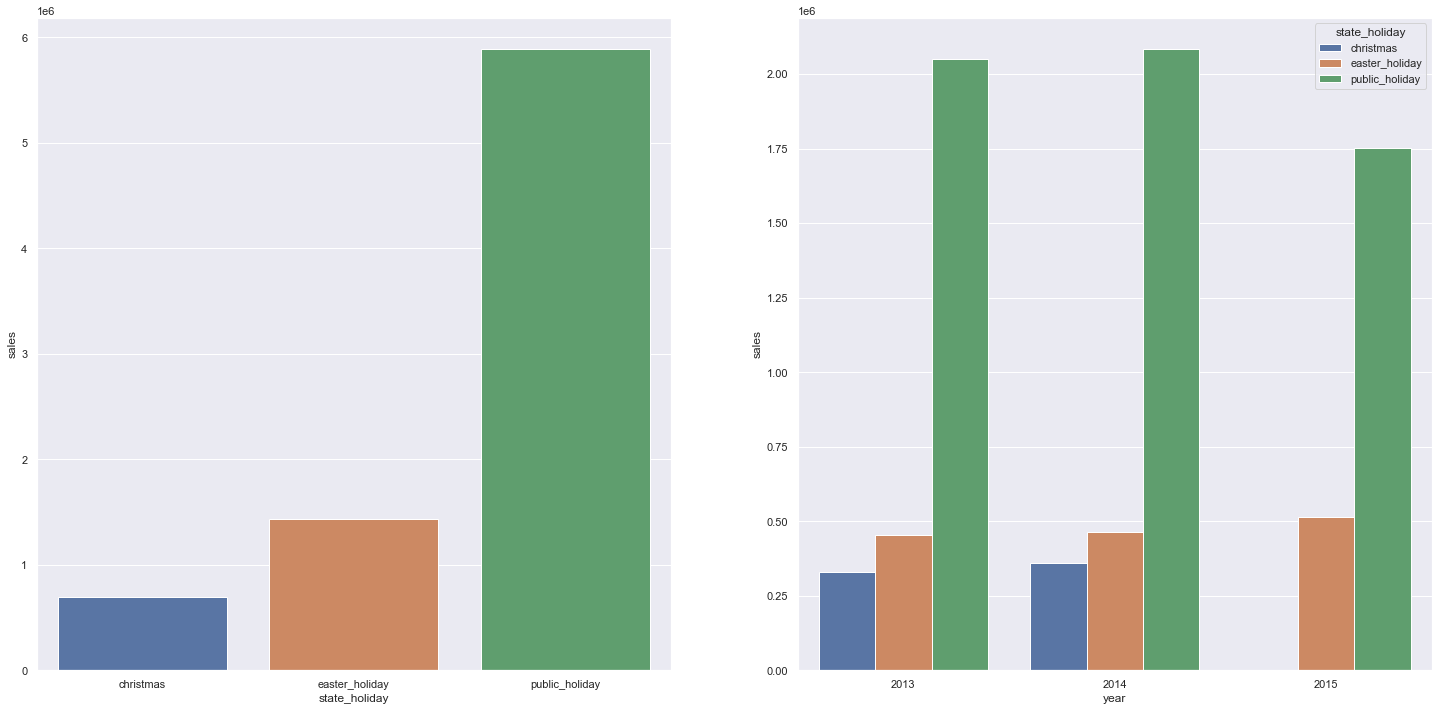

In [85]:
# excluindo as vendas de "regular_day" pois elas são proporcionalmente muito maiores do que qq feriado
aux1 = df4[df4['state_holiday'] != 'regular_day'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.subplot( 1, 2, 1)
sns.barplot( data=aux1, x='state_holiday', y='sales');

aux2 = df4[df4['state_holiday'] != 'regular_day'][['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()

plt.subplot( 1, 2, 2)
sns.barplot( data=aux2, x='year', y='sales', hue='state_holiday');

### Hipótese 8: Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas VENDEM MENOS ao longo dos anos

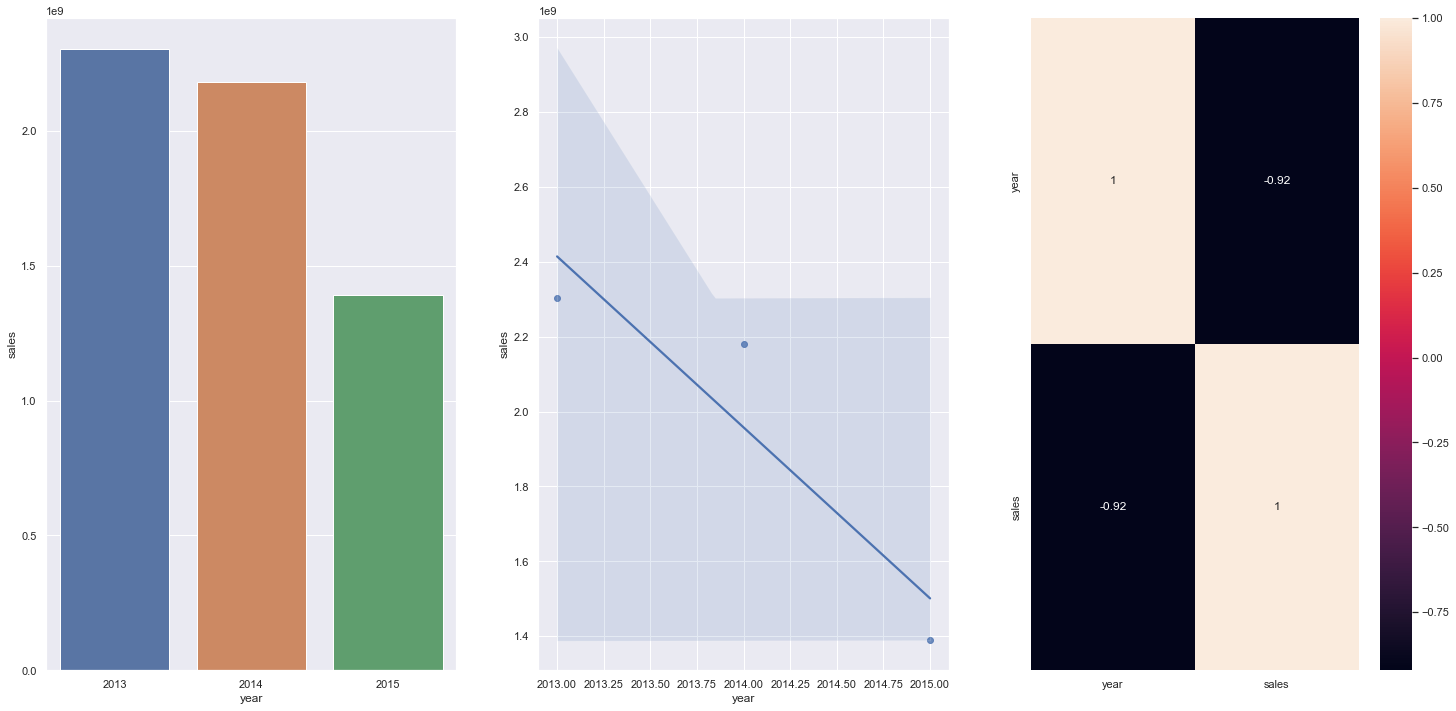

In [86]:
# excluindo as vendas de "regular_day" pois elas são proporcionalmente muito maiores do que qq feriado
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()


plt.subplot( 1, 3, 1)
sns.barplot( data=aux1, x='year', y='sales');


# gráfico de tendência
plt.subplot( 1, 3, 2)
sns.regplot( data=aux1, x='year', y='sales');

# gráfico de co-relação
plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### Hipótese 9:  Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**, Lojas VENDEM MENOS no segundo semestre do ano

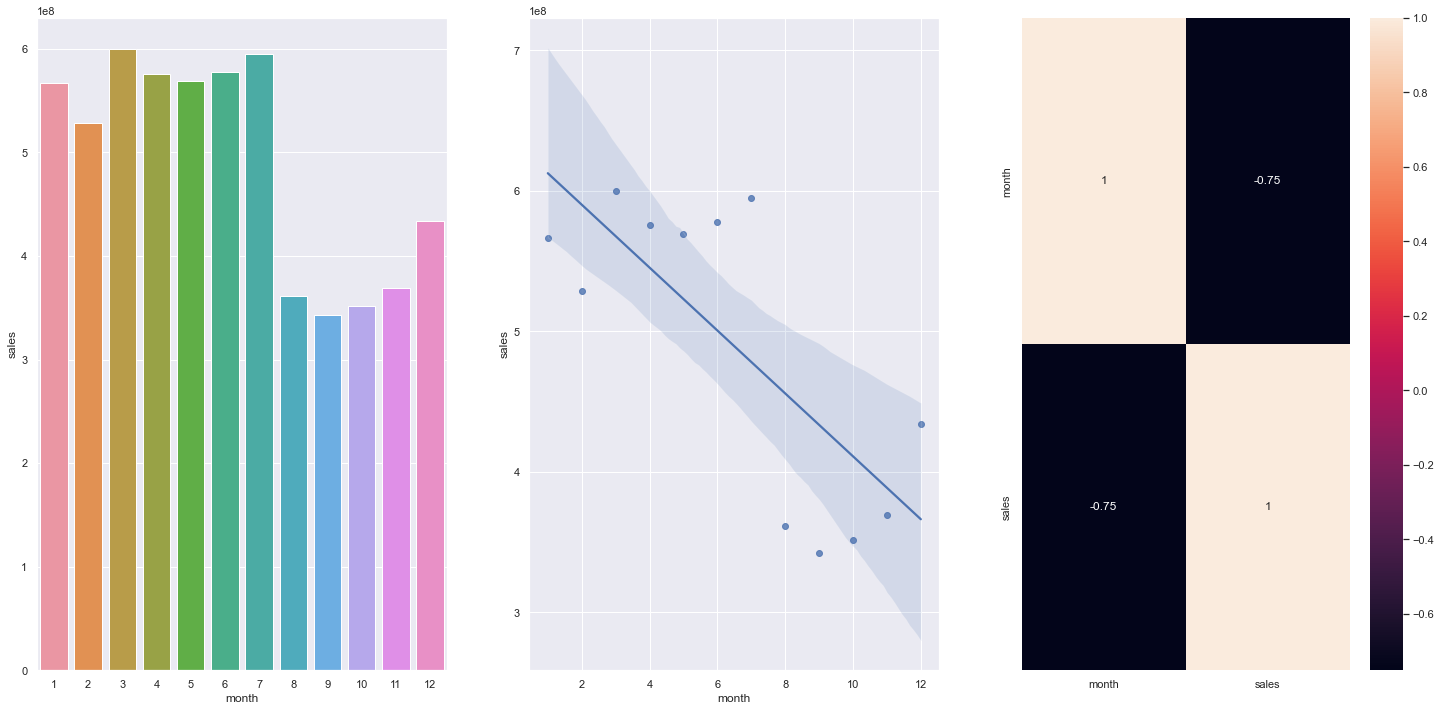

In [87]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( data=aux1, x='month', y='sales');


# gráfico de tendência
plt.subplot( 1, 3, 2)
sns.regplot( data=aux1, x='month', y='sales');

# gráfico de co-relação
plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);


### Hipótese 10:  Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**, Lojas VENDEM MAIS depois do dia 10 de cada mês

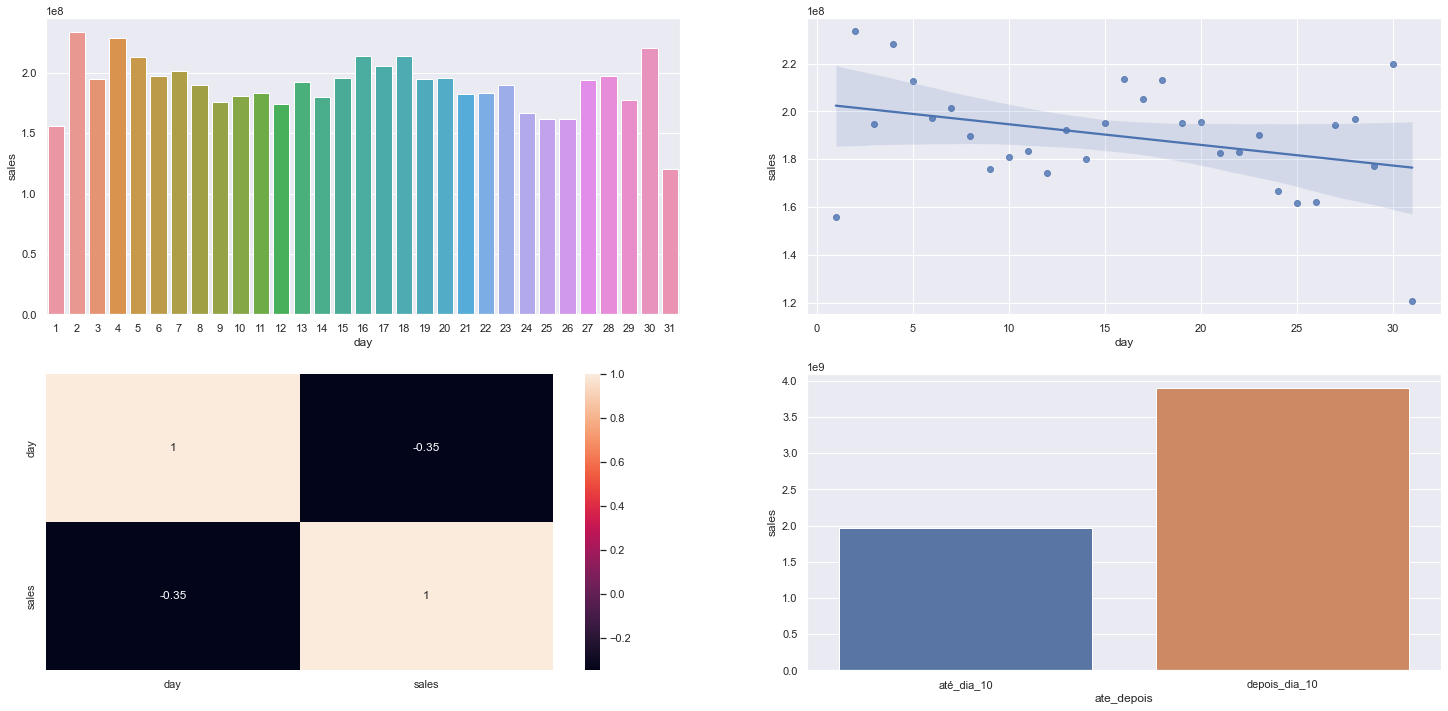

In [88]:
# criando campo para identificar se o dia é antes ou depois do dia 10
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot( data=aux1, x='day', y='sales');


# gráfico de tendência
plt.subplot( 2, 2, 2)
sns.regplot( data=aux1, x='day', y='sales');

# gráfico de co-relação
plt.subplot( 2, 2, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

# gráfico de barra agrupando por até e depois do dia 10
aux1['ate_depois'] = aux1['day'].apply( lambda x: 'até_dia_10' if x <= 10 else 'depois_dia_10')
aux2 = aux1[['ate_depois', 'sales']].groupby('ate_depois').sum().reset_index()

plt.subplot( 2, 2, 4)
sns.barplot( data=aux2, x='ate_depois', y='sales');

### Hipótese 11:  Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**, Lojas VENDEM MENOS nos finais de semana

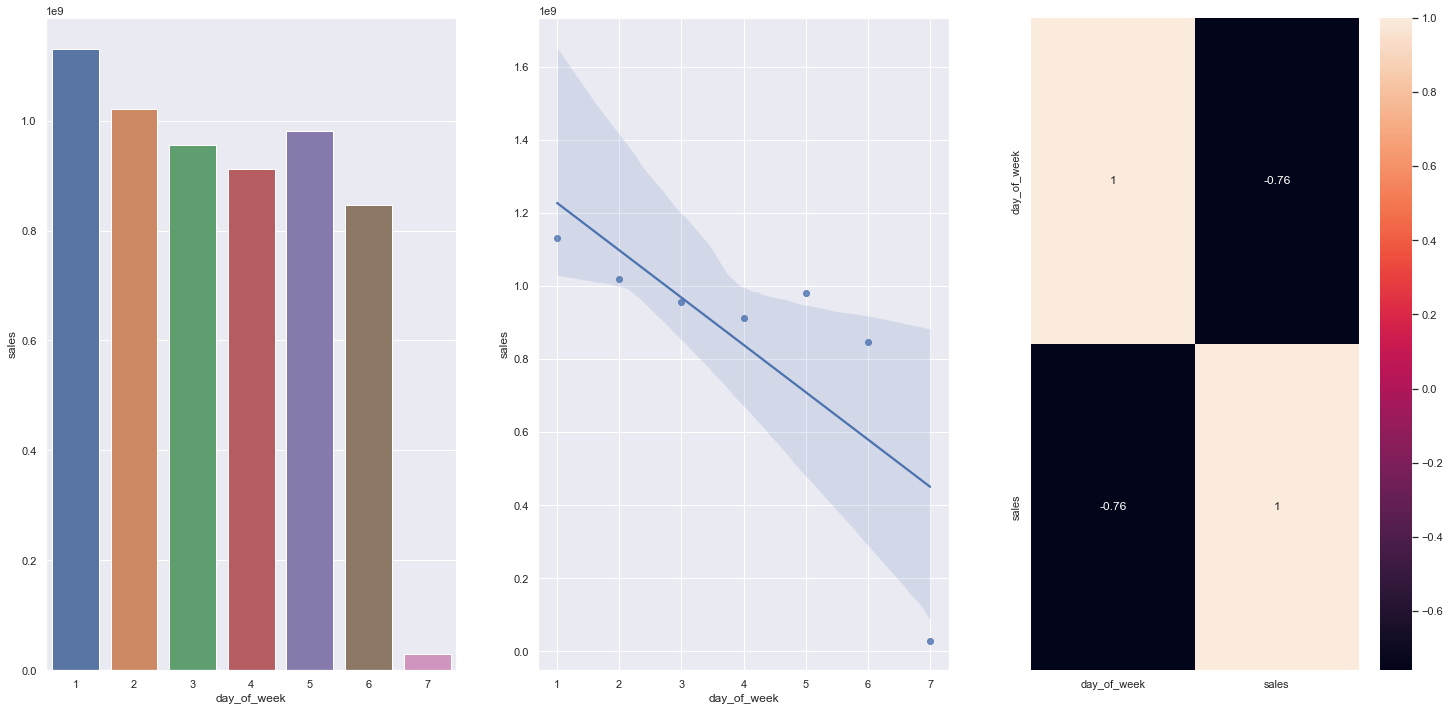

In [89]:
# criando campo para identificar se o dia é antes ou depois do dia 10
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( data=aux1, x='day_of_week', y='sales');


# gráfico de tendência
plt.subplot( 1, 3, 2)
sns.regplot( data=aux1, x='day_of_week', y='sales');

# gráfico de co-relação
plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);


### Hipótese 12:  Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** , Lojas VENDEM MENOS durante os feriados escolares, exceto meses de julho e agosto

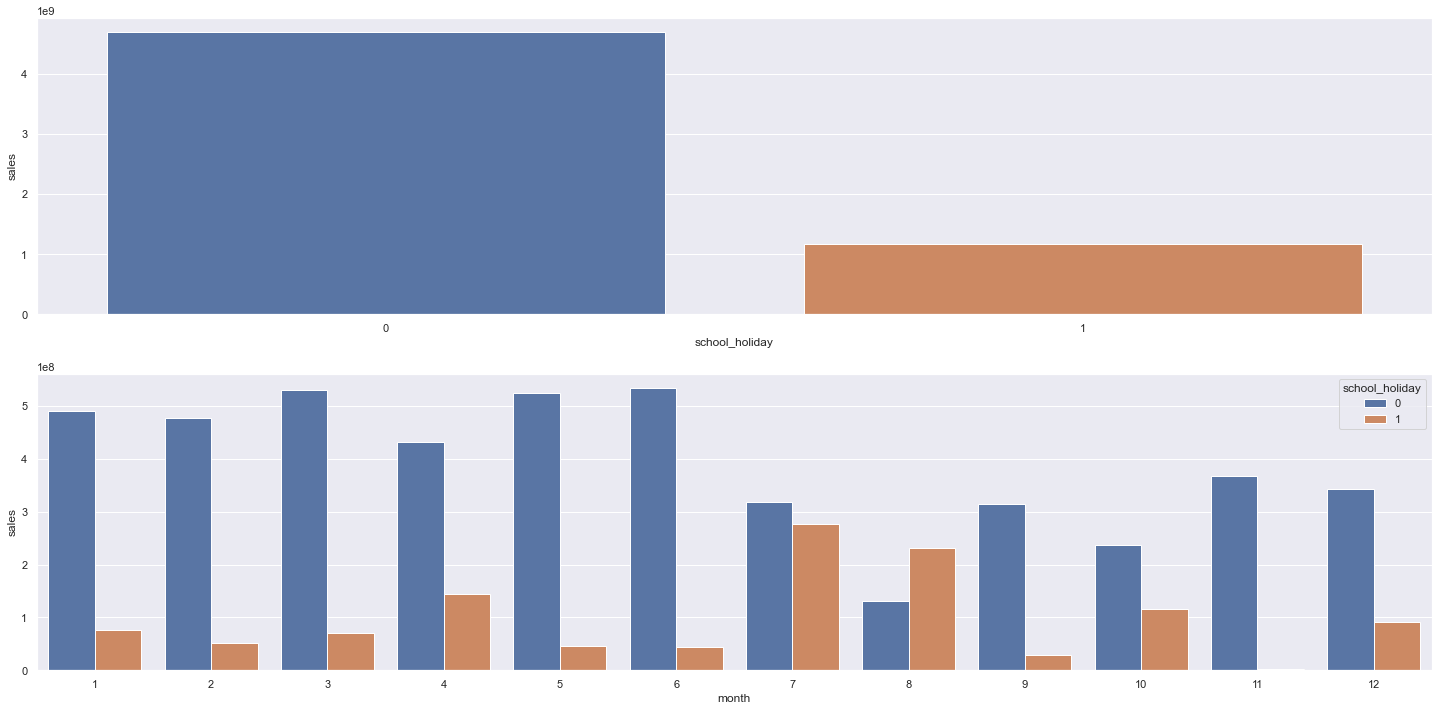

In [90]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot( 2, 1, 1)
sns.barplot( data=aux1, x='school_holiday', y='sales');

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot( 2, 1, 2)
sns.barplot( data=aux2, x='month', hue='school_holiday', y='sales');


### 4.2.1 Resumo das Hipóteses

In [91]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']
      ]
print( tabulate ( tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

## 4.3.1 Atributos Numéricos

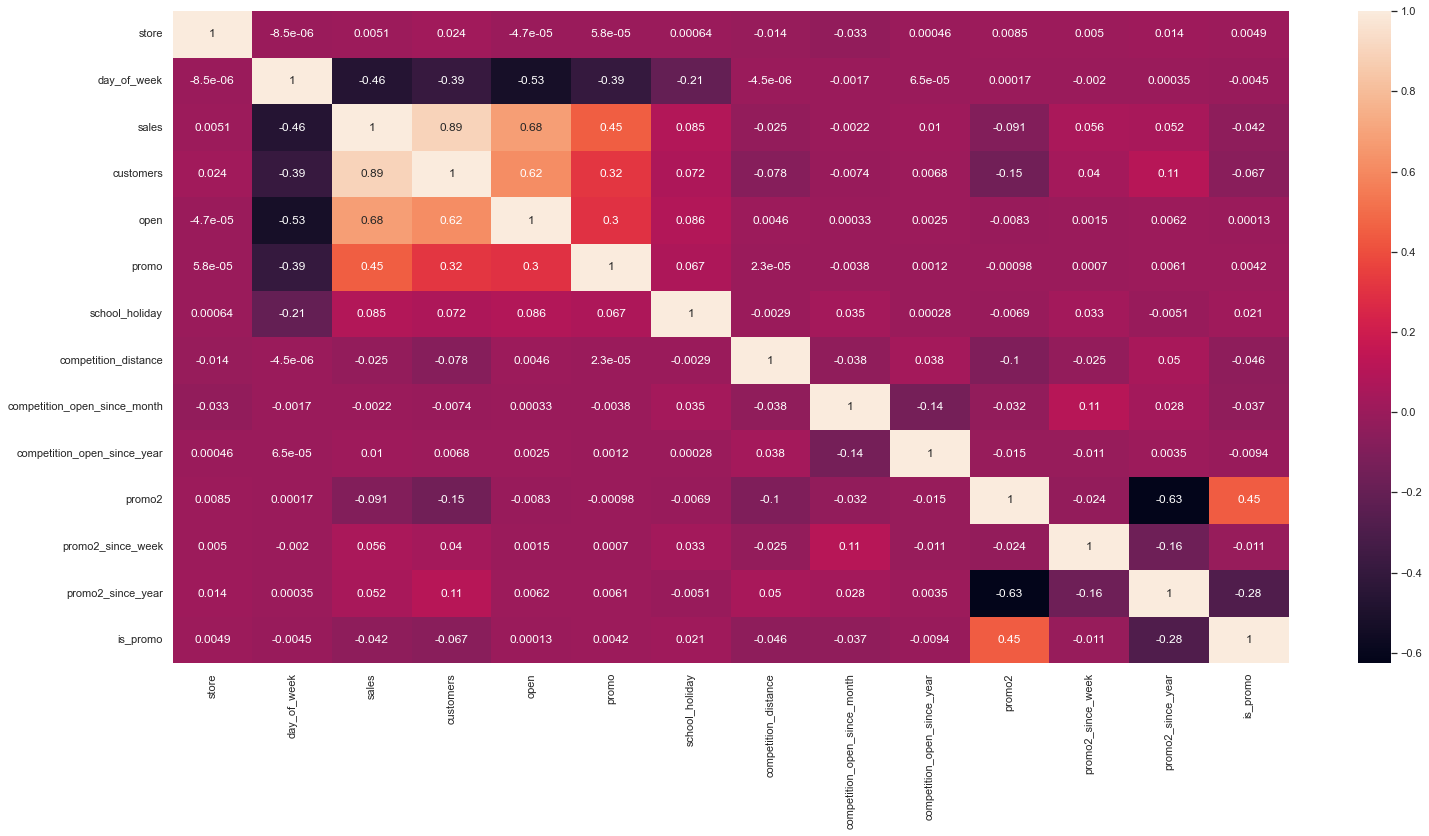

In [92]:
correlation = df_num.corr( method='pearson')
sns.heatmap( correlation, annot=True);

## 4.3.2 Atributos Categóricos

In [93]:
aux = df4.select_dtypes( include='object')
aux.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [94]:
# atribuindo o v_de_cramer para cada combinação das 3 variáveis categoricas
a1 = v_de_cramer( aux['state_holiday'], aux['state_holiday'] )
a2 = v_de_cramer( aux['state_holiday'], aux['store_type'] )
a3 = v_de_cramer( aux['state_holiday'], aux['assortment'] )

a4 = v_de_cramer( aux['store_type'], aux['state_holiday'] )
a5 = v_de_cramer( aux['store_type'], aux['store_type'] )
a6 = v_de_cramer( aux['store_type'], aux['assortment'] )

a7 = v_de_cramer( aux['assortment'], aux['state_holiday'] )
a8 = v_de_cramer( aux['assortment'], aux['store_type'] )
a9 = v_de_cramer( aux['assortment'], aux['assortment'] )

# criando o dataframe com os valores das combinações das variáveis categóricas
aux1 = pd.DataFrame( { 'state_holiday' : [a1, a2, a3],
                      'store_type'     : [a4, a5, a6],
                      'assortment'     : [a7, a8, a9] } )


# configurando o nome das linhas igual aos das colunas
aux1 = aux1.set_index( aux1.columns)
aux1.head()

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


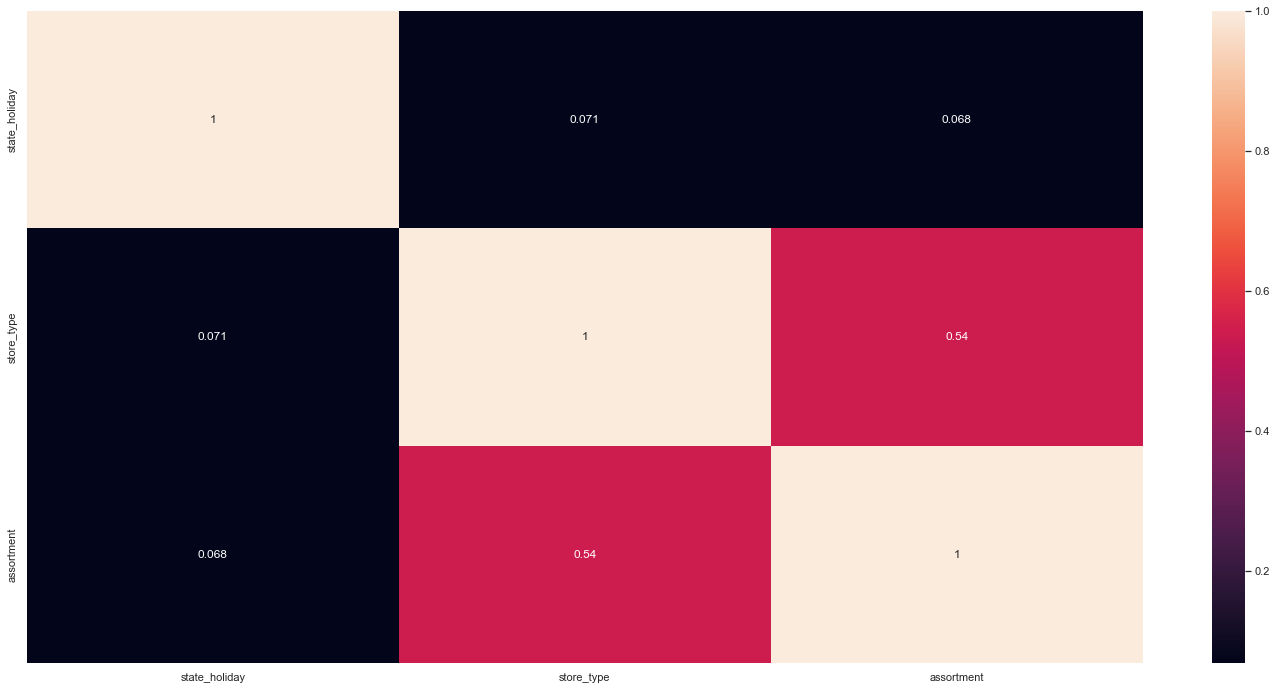

In [95]:
# plot a correlação entre variáveis categóricas, quanto mais próximo de zero menor a correlação, quanto mais próximo de um maior correlação
sns.heatmap( aux1, annot=True);

# 5.0 PREPARAÇÃO DOS DADOS

In [96]:
df5 = df4.copy()

## 5.1 Normalização

**Olhando a seção 4.1.2 Distribuição das variáveis numéricas, observamos que no nosso dataset não existem variáveis com distribuição NORMAL, desta forma, não faz sentido aplicarmos o método de normalização.**

## 5.2 Rescaling

In [97]:
aux = df5.select_dtypes( include=['int64', 'float64'])
aux.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


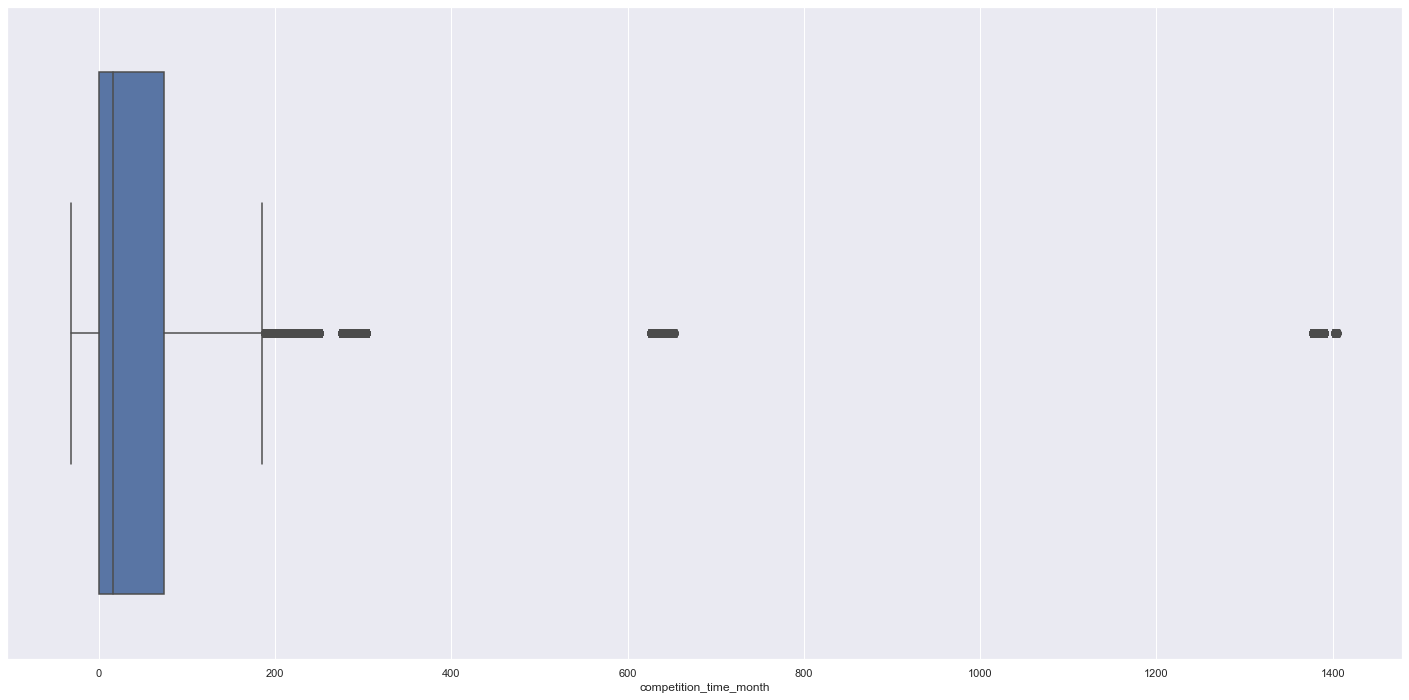

In [110]:
# Se os outliers forem relevantes, deve-se utilizar o método RobustScaler do sklearn
sns.boxplot( data=df5, x='competition_time_month');

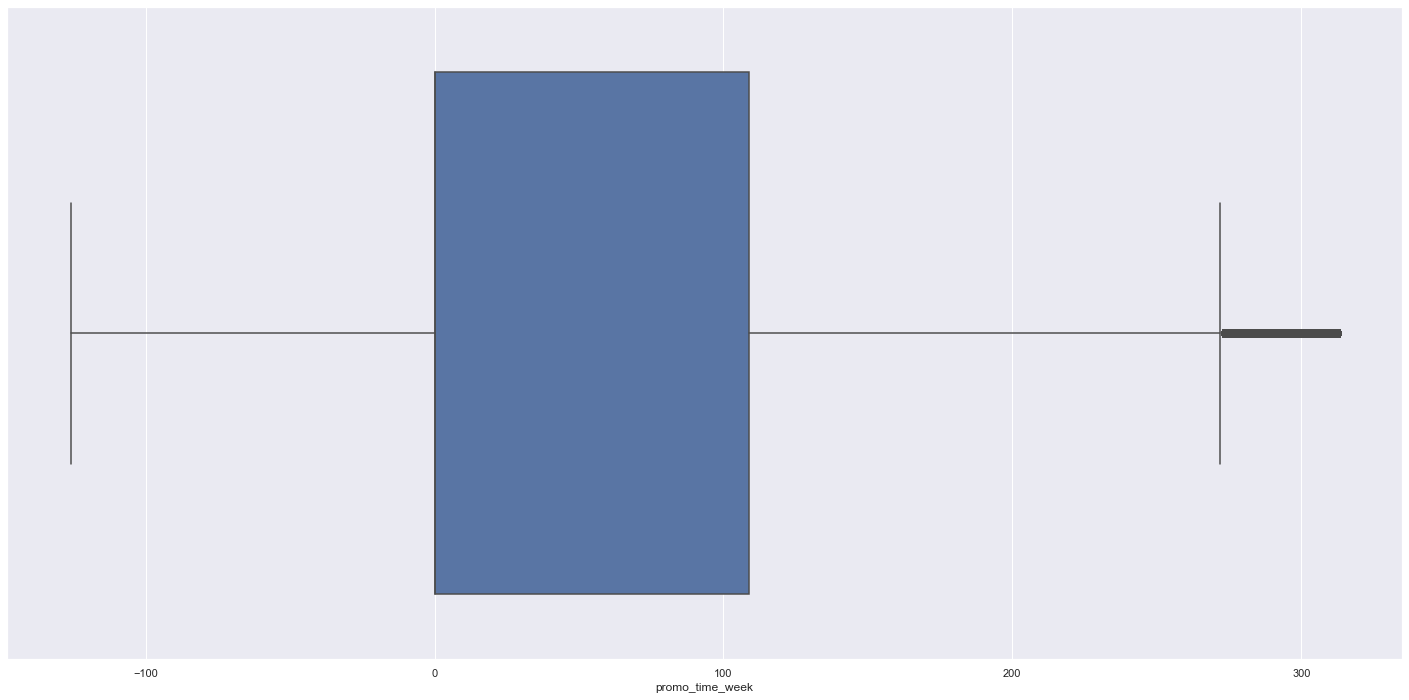

In [111]:
# Se os outliers NÃO forem relevantes, deve-se utilizar o método MinMaxScaler do sklearn
sns.boxplot( data=df5, x='promo_time_week');

In [113]:
# instancia a classe RobustScaler do sklearn
rs = RobustScaler()

# atribui para as variáveis os valores transformado pelo RobustScaler
df5['competition_distance']   = rs.fit_transform( df5[['competition_distance']].values )
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# instancia a classe MinMaxScaler do sklearn
mms = MinMaxScaler()

# atribui para as variáveis os valores transformado pelo MinMaxScaler
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
df5['year']            = mms.fit_transform( df5[['year']].values )



C:\Users\datam\Anaconda3\envs\my_projects_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


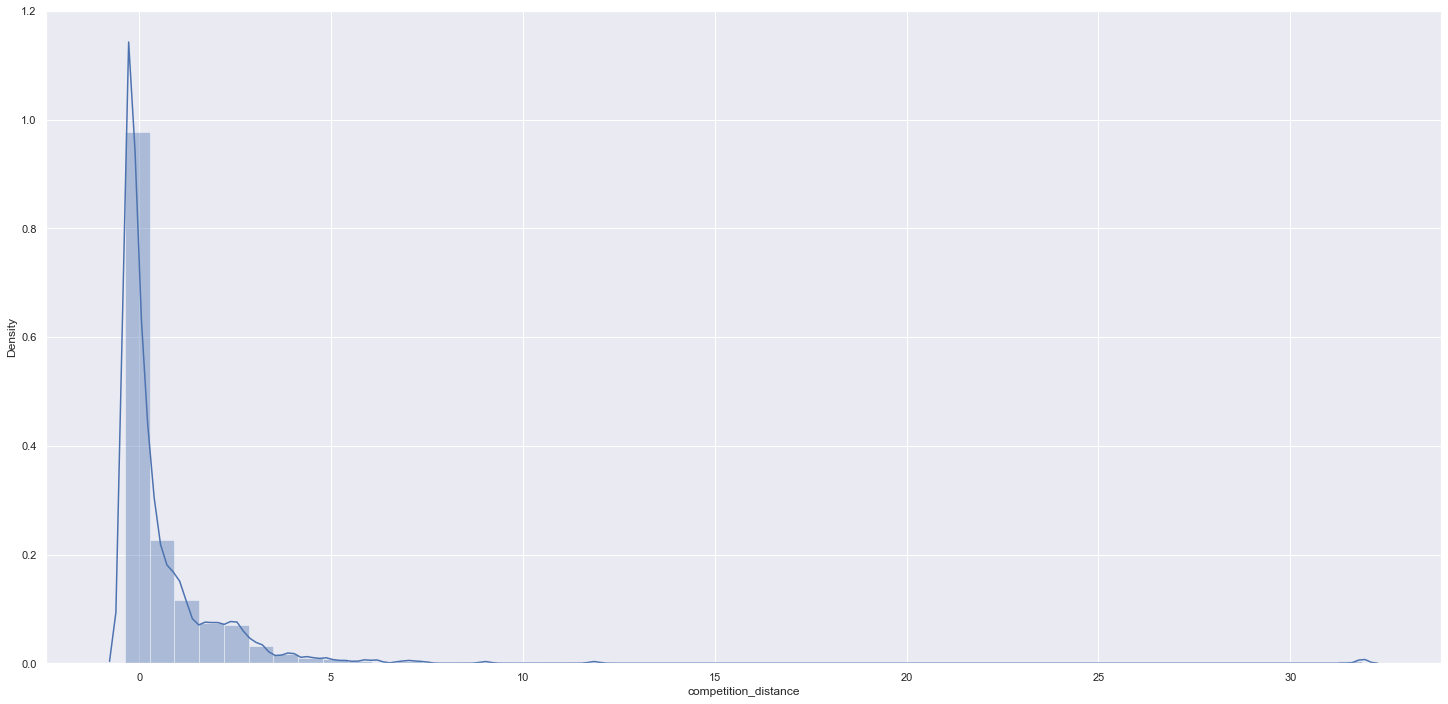

In [124]:
sns.distplot( df5['competition_distance']);

## 5.3 Transformação

### 5.3.1 Encoding (Utilizado para variáveis categóricas)

In [125]:
#state_holiday - Tipo de Encoding: One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [127]:
#store_type - Tipo de Encoding: Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [128]:
#assortment - Tipo de Encoding: Ordinal Encoding (utilizado quando o valor da variável indica uma ordem)
assortment_dict = { 'basic':1, 'extra':2, 'extended':3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2 Transformação da Variável Resposta (sales)

C:\Users\datam\Anaconda3\envs\my_projects_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

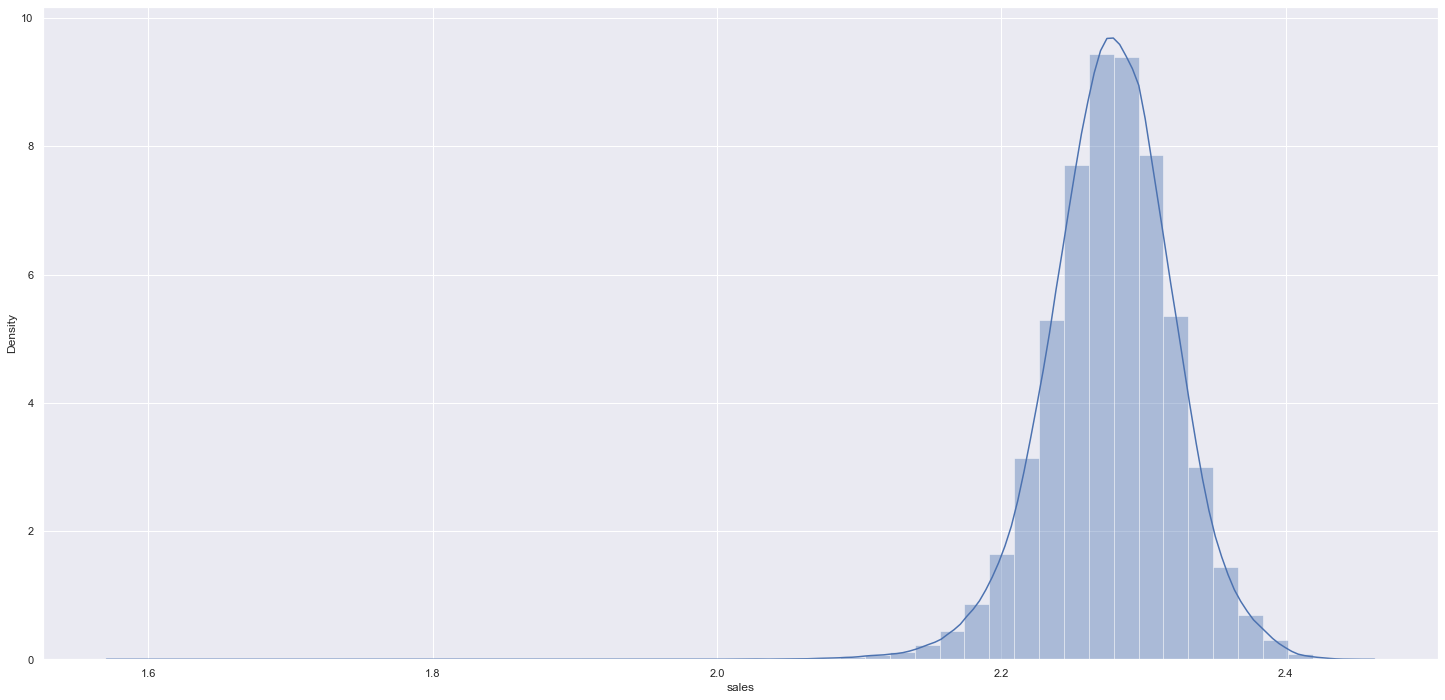

In [130]:
df5['sales'] = np.log1p( df5['sales'])
sns.distplot( df5['sales'])

### 5.3.3 Transformação por Natureza (Variáveis Cíclicas que dão ideias de ciclos, como mês, dia da semana, semanas do ano, etc....)

In [134]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,2.258492,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,2.273186,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,2.305163,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,2.355797,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,2.249306,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
